# Representation Analysis

## Setup

In [9]:
# based on: https://github.com/naver-ai/cl-vs-mim/blob/main/representation_analysis.ipynb
import torch
import timm
import matplotlib.pyplot as plt
from einops import rearrange, reduce, repeat
from timm.utils import AverageMeter
from functools import partial
import os
import math
import numpy as np
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import timm.data.transforms_factory as tff
from collections import defaultdict
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.manifold import TSNE
from einops import rearrange, reduce, repeat

### Utils

In [10]:
def get_layer(model, layer_name: str):
    layers = layer_name.split(".")
    for layer in layers:
        if layer.isnumeric():
            model = model[int(layer)]
        elif hasattr(model, layer):
            model = getattr(model, layer)
        else:
            raise ValueError(f"Layer {layer} not found in {model}")
    return model


def clean_tensor(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu()
    elif isinstance(tensor, tuple):
        return tuple(clean_tensor(t) for t in tensor)
    elif isinstance(tensor, list):
        return [clean_tensor(t) for t in tensor]
    elif isinstance(tensor, dict):
        return {k: clean_tensor(v) for k, v in tensor.items()}
    else:
        return tensor


class ActivationCache(object):
    def __init__(self, head_name: str="head"):
        self.cache = defaultdict(dict)
        self.hooks = {}
        self.head_name = head_name
        self.logger = logging.getLogger(__name__)

    def clear(self):
        self.cache = {}

    def _hook_fn(self, layer_name: str):
        def hook_fn(module, input, output):
            self.cache[layer_name]["input"] = clean_tensor(input)
            self.cache[layer_name]["output"] = clean_tensor(output)

        return hook_fn

    def hook_layer(self, model, layer_name: str):
        layer = get_layer(model, layer_name)
        # print(f"Hooking {layer_name}")
        self.logger.debug(f"Hooking {layer_name}: {layer.__class__}")
        hook = layer.register_forward_hook(self._hook_fn(layer_name))
        return hook

    def hook(self, model):
        # get Attention params: H, D
        self.H = model.blocks[0].attn.num_heads
        self.D = model.blocks[0].attn.proj.weight.shape[0]  # (D, D)

        # hook the layers
        self.n_blocks = len(model.blocks)
        for i in range(self.n_blocks):
            # deactivate fused_attn to get access to the individual components
            model.blocks[i].attn.fused_attn = False
            for layer_name in self._hooked_layers_per_block(i):
                self.hooks[layer_name] = self.hook_layer(model, layer_name)

        # hook the head 
        self.hooks[self.head_name] = self.hook_layer(model, self.head_name)
        # self.hooks[''] = model.register_forward_hook(self._hook_fn(''))

    def get_attn_ft(self, block_idx: int):
        proj_input = self.cache[f"blocks.{block_idx}.attn.proj"]["input"][0]
        B, N, _ = proj_input.shape

        # attn_ft: B, H, N, C//H
        # proj_input = attn_ft.transpose(1, 2).reshape(B, N, C)
        # reverse operation
        attn_ft = proj_input.reshape(B, N, self.H, self.D // self.H).transpose(1, 2)
        return attn_ft

    def get_attn(self, block_idx: int):
        return self.cache[f"blocks.{block_idx}.attn.attn_drop"]["output"]
    
    def get_attns(self):
        attns = []
        for idx in range(self.n_blocks):
            attns.append(self.get_attn(idx))
        return attns

    def get_zs(self):
        # zs: 0 = input of first block, same as input of first norm1
        # zs: i = input of norm2 of block i // 2 + 1
        # zs: i+1 = output of block i // 2 + 2, same as input of norm1 of the next block :0
        # zs: n = output of head, same as output of model
        zs = []
        zs.append(self.cache["blocks.0"]["input"][0])
        for idx in range(self.n_blocks):
            """
            class Block:
                def forward(self, x: torch.Tensor) -> torch.Tensor:
                    x = x + self.drop_path1(self.ls1(self.attn(self.norm1(x))))
                    ---> hook on this x
                    x = x + self.drop_path2(self.ls2(self.mlp(self.norm2(x))))
                    ---> hook on this x
                    return x
            """
            z1 = self.cache[f"blocks.{idx}.norm2"]["input"][0]
            # zs.append(self.cache[f'blocks.{idx}']['output'])
            #   This works too for standard timm ViTs,
            #   but not for custom Blocks that output multiple tensors,
            #   like the cl_vs_mim ViT
            mlp_output = self.cache[f"blocks.{idx}.mlp"]["output"]
            z2 = mlp_output + z1
            zs.extend([z1, z2])

        # TODO: careful, this could change depending on the model
        # zs.append(self.cache['']['output'])
        try: 
            zs.append(self.cache[self.head_name]["output"])
        except KeyError:
            self.logger.warning(f"Head output not found in cache. Appending None.")
            zs.append(None)
        return zs

    @staticmethod
    def _hooked_layers_per_block(i):
        return [
            f"blocks.{i}",  # input -> zs[0]
            f"blocks.{i}.norm2",  # input -> zs[i]
            f"blocks.{i}.mlp",  # output + zs[i] -> zs[i+1]
            f"blocks.{i}.attn.attn_drop",  # output -> attn
            f"blocks.{i}.attn.proj",  # input -> attn_ft
        ]

    def unhook(self):
        for hook in self.hooks.values():
            hook.remove()
        self.hooks = {}


In [11]:
def subsample(dataset, ratio, random=False):
    """
    Get indices of subsampled dataset with given ratio.
    """
    idxs = list(range(len(dataset)))
    idxs_sorted = {}
    for idx, target in zip(idxs, dataset.targets):
        if target in idxs_sorted:
            idxs_sorted[target].append(idx)
        else:
            idxs_sorted[target] = [idx]

    for idx in idxs_sorted:
        size = len(idxs_sorted[idx])
        lenghts = (int(size * ratio), size - int(size * ratio))
        if random:
            idxs_sorted[idx] = torch.utils.data.random_split(idxs_sorted[idx], lenghts)[0]
        else:
            idxs_sorted[idx] = idxs_sorted[idx][:lenghts[0]]

    idxs = [idx for idxs in idxs_sorted.values() for idx in idxs]
    return idxs

### Dataset

In [12]:

# !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz -P ~/development/datasets
# !gunzip ~/development/datasets/imagenette2-160.tgz -d ~/development/datasets
# !tar -xvf ~/development/datasets/imagenette2-160.tar -C ~/development/datasets

In [13]:

# use imagenette (a small subset of imagenet) as an example for simplicity
imagenet_path = "~/development/datasets/imagenette2-160"

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

transform_test = tff.transforms_imagenet_eval(
    img_size=224, mean=imagenet_mean, std=imagenet_std,
)

test_dir = os.path.join(imagenet_path, 'val')
dataset_test = datasets.ImageFolder(test_dir, transform_test)
dataset_test = torch.utils.data.Subset(
    dataset_test, 
    subsample(dataset_test, ratio=math.pow(2,-6))  # use a subsampled batch
)

dataset_test = DataLoader(
    dataset_test, 
    num_workers=1, 
    batch_size=64,
)

## Load the Models

In [14]:
def load_dora():
    return torch.hub.load("dgcnz/DoRA_ICLR24", model="vit_small_patch16_224_dora_wt_venice_ep100").cuda().eval()

In [15]:
def load_dino():
    return timm.create_model('vit_small_patch16_224.dino', pretrained=True).cuda().eval()

## Fourier Analysis

Running dora


Using cache found in /home/dgcnz/.cache/torch/hub/dgcnz_DoRA_ICLR24_main


Take key teacher in provided checkpoint dict
Pretrained weights found at vit_small_patch16_224.dora.wt_venice.ep100.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


Head output not found in cache. Appending None.


torch.Size([25, 7])
Running DINO


model.safetensors:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

torch.Size([25, 7])


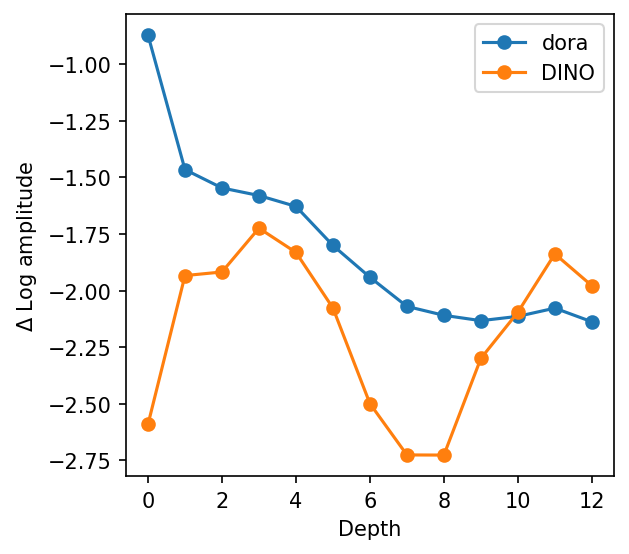

In [16]:
# build off the implementation of https://github.com/xxxnell/how-do-vits-work


def fourier(x):
    """2D Fourier transform"""
    f = torch.fft.fft2(x)
    f = f.abs() + 1e-6
    f = f.log()
    return f

def shift(x):  
    """shift Fourier transformed feature map"""
    b, c, h, w = x.shape
    return torch.roll(x, shifts=(int(h/2), int(w/2)), dims=(2, 3))

def get_fourier_latents(latents):
    """Fourier transform feature maps"""
    fourier_latents = []
    for latent in latents:  # `latents` is a list of hidden feature maps in latent spaces
        latent = latent.cpu()
        b, n, c = latent.shape
        h, w = int(math.sqrt(n)), int(math.sqrt(n))
        latent = rearrange(latent, "b (h w) c -> b c h w", h=h, w=w)
        
        latent = fourier(latent)
        latent = shift(latent).mean(dim=(0, 1))
        latent = latent.diag()[int(h/2):]  # only use the half-diagonal components
        latent = latent - latent[0]  # visualize 'relative' log amplitudes 
                                     # (i.e., low-freq amp - high freq amp)
        fourier_latents.append(latent)

    return fourier_latents

fig, ax = plt.subplots(1, 1, figsize=(4.2, 4), dpi=150)
models = {
    "dora": load_dora,
    "DINO": load_dino,
}

for label, loader in models.items():
    print(f"Running {label}")
    model = loader()
    head_name = "clf" if label == "PARTv1_ft" else "head"
    act = ActivationCache(head_name)
    # act.logger.setLevel(logging.DEBUG)
    act.hook(model)
    fourier_latents = AverageMeter()
    for i, (xs, ys) in enumerate(dataset_test):
        with torch.no_grad():
            xs = xs.cuda()
            _ = model(xs)

        zs = act.get_zs()
        zs = zs[:-1] # skips model output

        # if model has cls token remove it
        if model.cls_token is not None:
            latents = [z[:,1:,:] for z in zs]
        else:
            latents = [z for z in zs]
        _fourier_latents = torch.stack(get_fourier_latents(latents))
        fourier_latents.update(_fourier_latents)

        if i > -1:
            break

    print(fourier_latents.avg.shape)       
    fourier_latents = fourier_latents.avg
    ax.plot(range(13), fourier_latents[:,-1][::2], marker="o", label=label)

ax.set_xlabel("Depth")
ax.set_ylabel("$\Delta$ Log amplitude")
# ax.set_ylim(top=-3, bottom=-3.5)
ax.legend()
plt.show()
